In [1]:
# Purpose:  Apply canned sentiment analyzers fron the TextBlob package to predict manually-assigned tweet sentiment.
#   This version applies them to precleaned sample election data, not the Kaggle data.
# Author:  Carol Sniegoski
# Date:  05/05/16
# Course:  MAS DSE capstone, Spring 2016

In [7]:
import pandas as pd
from textblob import TextBlob
from textblob import Blobber
from textblob.taggers import NLTKTagger
from textblob.sentiments import NaiveBayesAnalyzer

import matplotlib.pylab as plt
%matplotlib inline
import math

pd.set_option('display.max_colwidth', 240)
pd.set_option('display.max_columns', 50)

print 'done'


done


In [8]:
# Function defs.

# Get the textblob's sentiment.
# If using the default sentiment analyzer, this is a named tuple of (polarity, subjectivity).
# If using the NaiveBayesAnalyzer, this is a named tuple of (classification, p_pos, p_neg).
def get_blob_sentiment(b):
    return b.sentiment

# Return string with non-ascii chars removed.
def to_ascii(s):
    returnstr = s.strip()
    returnstr = "".join([ch for ch in returnstr if ord(ch)< 128])
    return returnstr

# Return count of rows in which col1 == col2.
def get_agreement(df, col1, col2):
    return df[df[col1]==df[col2]].shape[0]

# Return df representing confusion matrix. Col1 values are the rows, col2 values are the columns.
def get_confusion_matrix(df, row_col, col_col):
    vals = pd.unique(df[[row_col, col_col]].values.ravel())
    print type(vals)
    print "vals=", vals
    vals.sort()
    
    rows_list = []
    for row_val in vals:
        dict = {row_col:row_val}
        for col_val in vals:
            count = df[ (df[row_col]==row_val) & (df[col_col]==col_val) ].shape[0]
            dict[col_val] = count
        rows_list.append(dict)
    #conf_df = pd.DataFrame(rows_list[1:]) 
    conf_df = pd.DataFrame(rows_list)
    return conf_df

print 'done'

done


In [9]:
# Locate the data.
%ls ../data/sentiment

Labeled_electionTweets_randomSample_allPartitions_04-26-16.csv      bing-liu_opinion-lexicon-English_d04-13-16.rar
Labeled_electionTweets_randomSample_allPartitions_04-26-16.csv.bak  debate08_sentiment_tweets.tsv
Labeled_electionTweets_randomSample_allPartitions_04-30-16.csv      debate08_sentiment_tweets.tsv.zip
Labeled_electionTweets_randomSample_allPartitions_05-04-16.csv      hashtag_173_top200_byCandidateAndSentiment_05-03-16.csv
Labeled_electionTweets_randomSample_allPartitions_05-04-16.csv.bak  opinion-lexicon-English.rar


In [10]:
# Define variables.

clean_text = 'ascii_clean'
data_dir = "../data/sentiment/"
datafile_name = "Labeled_electionTweets_randomSample_allPartitions_05-04-16.csv"
datafile = data_dir + datafile_name
print datafile

../data/sentiment/Labeled_electionTweets_randomSample_allPartitions_05-04-16.csv


In [11]:
# Load datafile.
df = pd.read_csv(datafile)
#df=df.rename(columns = {'label':'label_LinearSVC_char3grams_0.75sample'})
print df.shape
df.head(2)

(1859, 17)


,Unnamed: 0,Unnamed: 0.1,text,ascii,ascii_clean,label_LinearSVC_char3grams_0.75sample,label_cas_04-27-16,label_LinearSVC_char3grams_0.75randomsample_2016-04-27,label_RandomForest_char3grams_0.75randomsample_2016-04-28,label_LinearSVC_char3grams_originaldata_2016-04-28,label_RandomForest-d5_char3grams_originaldata_2016-04-28,label_LinearSVC_char3grams_1.8randomsample_2016-04-29,label_cas_subj,label_cas_word-sentiment,label_cas_msg-sentiment,label_cas_msg-sentiment_confidence,label_cas_sentiment-candidate
0,0,0,"RT @ggreenwald: Clinton sadly never complained about ""overclassification run amok"" when whistleblowers &amp; sources were prosecuted... https:/…","RT @ggreenwald: Clinton sadly never complained about ""overclassification run amok"" when whistleblowers &amp; sources were prosecuted... https:/",rt @ggreenwald clinton sadly never complained about overclassification run amok when whistleblowers sources were prosecuted... url,Negative,Negative,Negative,Negative,Negative,Negative,Negative,1,-1,-1,1,Clinton-
1,1,1,Father: Ted Cruz’s success depends on people of faith https://t.co/sXviGD11Xw https://t.co/T0cdqrNowK,Father: Ted Cruzs success depends on people of faith https://t.co/sXviGD11Xw https://t.co/T0cdqrNowK,father ted cruzs success depends on people of faith url url,Negative,Neutral,Negative,Neutral,Negative,Negative,Neutral,0,0,0,0,Cruz0


In [487]:
# Assign sentiment using TextBlob's default analyzer. 
# This is based on pattern analysis and a lexicon.
# It returns named tuple of floats ( polarity, subjectivity ).
# Polarity is -1 to 1, with 1 being the most positive. Subjectivity is 0 to 1, with 1 being the most subjective.

b = Blobber(pos_tagger=NLTKTagger())
df['blob'] = df[clean_text].apply(b)
df['b_sentiment_num'] = df['blob'].apply(get_blob_sentiment)
df['b_polarity_num'] = df['b_sentiment_num'].apply(lambda x: x.polarity)
df['b_subjectivity_num'] = df['b_sentiment_num'].apply(lambda x: x.subjectivity)

# Set thresholds for mapping numeric polarity and subjectivity values to Postive, Negative, Neutral class labels.
# You can tweak these as you like, but the results are never that good.
SUBJ_THRESHOLD = .03  # If numeric subjectivity value < SUBJ_THRESHOLD, assign sentiment Neutral.
POS_THRESHOLD = .1    # If sentiment is not Neutral, and numeric polarity rating > POS_THRESHOLD, assign sentiment Positive.
NEG_THRESHOLD = .1    # If sentiment is not Neutral, and numeric polarity rating < NEG_THRESHOLD, assign sentiment Negative.

df['b_sentiment'] = 'Nothing'

# Don't use this approach - it updates a copy of a slice of the df, not the df itself.
#df['b_sentiment'][ (df['b_subjectivity_num']>=SUBJ_THRESHOLD) & (df['b_polarity_num']>POS_THRESHOLD) ] = 'Positive'
#df['b_sentiment'][ (df['b_subjectivity_num']>=SUBJ_THRESHOLD) & (df['b_polarity_num']<NEG_THRESHOLD) ] = 'Negative'

# Use this approach.
#df.loc[df['Age'] > 40, 'Age_Group'] = '>40'
df.loc[ ((df['b_subjectivity_num']<=SUBJ_THRESHOLD)), 'b_sentiment' ] = 'Neutral'
df.loc[ ((df['b_subjectivity_num']>SUBJ_THRESHOLD) & (df['b_polarity_num']>=POS_THRESHOLD)), 'b_sentiment' ] = 'Positive'
df.loc[ ((df['b_subjectivity_num']>SUBJ_THRESHOLD) & (df['b_polarity_num']<NEG_THRESHOLD)), 'b_sentiment' ] = 'Negative'

print 'done'
print df[['K_sentiment', 'b_sentiment', 'b_polarity_num', 'b_subjectivity_num', 'ascii']].head(2)           

done
  K_sentiment b_sentiment  b_polarity_num  b_subjectivity_num  \
0     Neutral    Positive           0.125            0.158333   
1    Positive    Positive           0.450            0.305556   

                                                                                                                    ascii  
0                 RT NancyLeeGrahn How did everyone feel about the Climate Change question last night? Exactly. GOPDebate  
1  RT ScottWalker Didnt catch the full GOPdebate last night. Here are some of Scotts best lines in 90 seconds. Walker16    


In [489]:
# Check agreement between truth sentiment assignments & TextBlob assignments.

agr = get_agreement(df, 'K_sentiment', 'b_sentiment')
denom = df.shape[0]
print float(agr)*100/denom, "% agreement (", agr, "out of", denom, ")"

confusion_df = get_confusion_matrix(df, 'K_sentiment', 'b_sentiment')
print confusion_df
print 'done'

# Wow, these results are really poor.

41.9147862447 % agreement ( 5814 out of 13871 )
<type 'numpy.ndarray'>
vals= ['Neutral' 'Positive' 'Negative']
  K_sentiment  Negative  Neutral  Positive
0    Negative      3234     3043      2216
1     Neutral       835     1401       906
2    Positive       349      708      1179
done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13cc20790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x156e8e390>]], dtype=object)

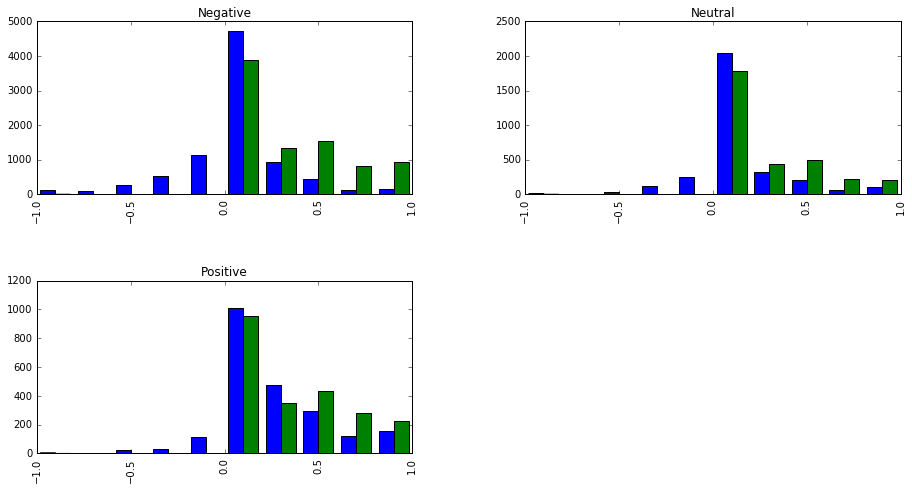

In [490]:
# Create histograms of polarity & subjectivity, by truth sentiment.

df[['b_polarity_num', 'b_subjectivity_num']].hist(by=df['K_sentiment'], figsize=(15,8))
#df.plot(figsize=(10,4))

# Positive Kaggle-assigned tweets skew positive, but negative Kaggle-assigned tweets don't skew
# that negative, and all Kaggle categories contain many neutrai tweets.

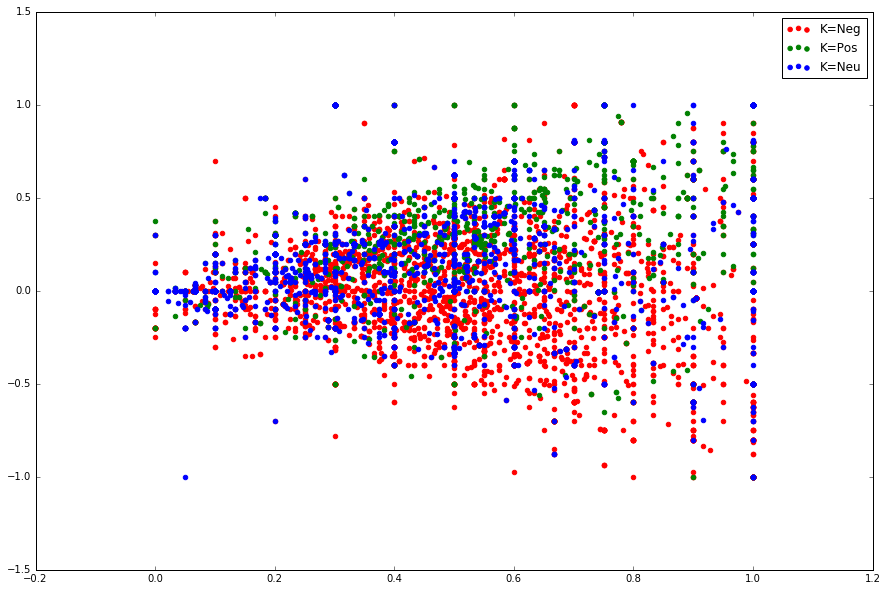

In [493]:
# Create scatter plot of polarity vs subjectivity, colored by truth sentiment.

def sigmoid(x):
    return 1 + (1/(1+math.exp(-100000*x)))
    

#plt.scatter(df['K_sentiment'].values.tolist(), df['b_sentiment'].values.tolist())
#plt.scatter( df['b_subjectivity_num'].values.tolist(), df['b_polarity_num'].values.tolist())
#plt.scatter( df.b_subjectivity_num, df.b_polarity_num, s=df.sentiment_confidence.apply(sigmoid))
#plt.scatter( df.b_subjectivity_num, df.b_polarity_num, s=df.retweet_count/20)
#df.plot.scatter()
#type(df['K_sentiment'].values.tolist())

K_neg = df[df['K_sentiment']=="Negative"]
K_pos = df[df['K_sentiment']=="Positive"]
K_neu = df[df['K_sentiment']=="Neutral"]
plt.figure(figsize=(15,10))
#plt.scatter( K_neg.b_subjectivity_num, K_neg.b_polarity_num, s=K_neg.retweet_count/5, c='r', edgecolor='r', label='K=Neg')
#plt.scatter( K_pos.b_subjectivity_num, K_pos.b_polarity_num, s=K_pos.retweet_count/5, c='g', edgecolor='g', label='K=Pos')
#plt.scatter( K_neu.b_subjectivity_num, K_neu.b_polarity_num, s=K_neu.retweet_count/5, c='b', edgecolor='b', label='K=Neu')
plt.scatter( K_neg.b_subjectivity_num, K_neg.b_polarity_num, s=20, c='r', edgecolor='r', label='K=Neg')
plt.scatter( K_pos.b_subjectivity_num, K_pos.b_polarity_num, s=20, c='g', edgecolor='g', label='K=Pos')
plt.scatter( K_neu.b_subjectivity_num, K_neu.b_polarity_num, s=20, c='b', edgecolor='b', label='K=Neu')
plt.legend()


#cond = df.col3 > 300
#subset_a = df[cond].dropna()
#subset_b = df[~cond].dropna()
#plt.scatter(subset_a.col1, subset_a.col2, s=120, c='b', label='col3 > 300')
#plt.scatter(subset_b.col1, subset_b.col2, s=60, c='r', label='col3 <= 300') 
#plt.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13cc20850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1578959d0>]], dtype=object)

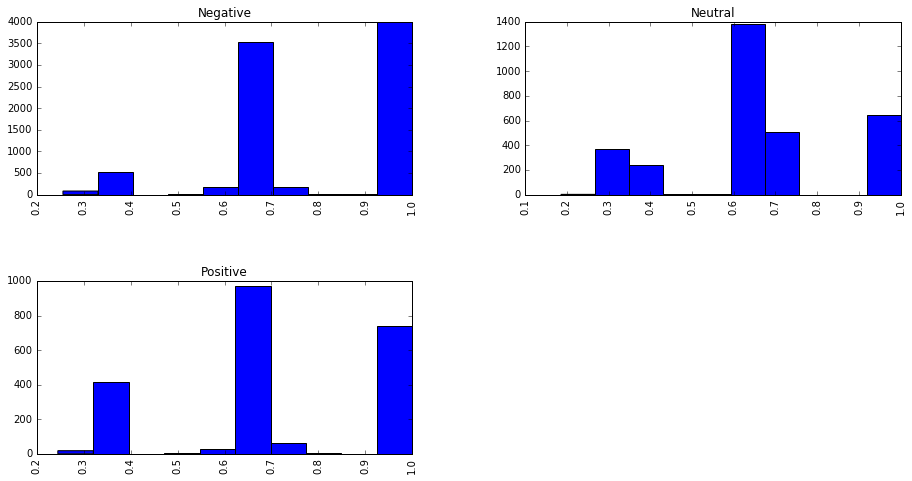

In [491]:
# Create histogram of Kaggle-assigned sentiment confidence. Maybe higher-confidence labels are classified better.
df[['sentiment_confidence']].hist(by=df['K_sentiment'], figsize=(15,8))

done


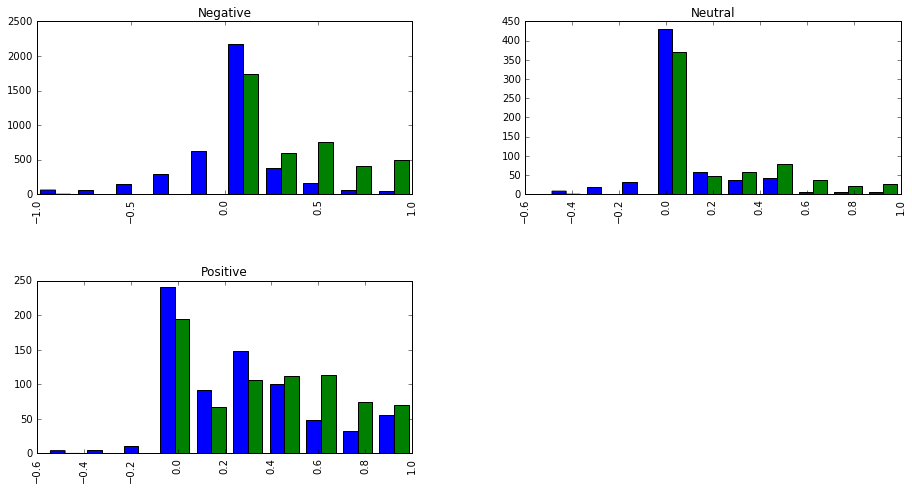

In [479]:
# Now create histograms of polarity & subjectivity, by Kaggle-assigned sentiment, by Kaggle sentiment confidence.

#test_df = df[df['sentiment_confidence']>.5][['b_polarity_num', 'b_subjectivity_num']]
df[df['sentiment_confidence']>.9][['b_polarity_num', 'b_subjectivity_num']].hist(by=df['K_sentiment'], figsize=(15,8))
#df[['b_polarity_num', 'b_subjectivity_num']].hist(by=df['K_sentiment'], figsize=(15,8))

print 'done'

In [492]:
# Check whether agreement is better for high-confidence Kaggle assignments.

temp_df = df[df['sentiment_confidence']>.8]
agr = get_agreement(temp_df, 'K_sentiment', 'b_sentiment')
denom = temp_df.shape[0]
print float(agr)*100/denom, "% agreement (", agr, "out of", denom, ")"

confusion_df = get_confusion_matrix(temp_df, 'K_sentiment', 'b_sentiment')
print confusion_df
print 'done'

# Agreement is somewhat better, but still poor.

46.6629485034 % agreement ( 2510 out of 5379 )
<type 'numpy.ndarray'>
vals= ['Positive' 'Negative' 'Neutral']
  K_sentiment  Negative  Neutral  Positive
0    Negative      1714     1399       885
1     Neutral       168      322       152
2    Positive        74      191       474
done


In [496]:
# Now perform sentiment analysis using the NaiveBayesAnalyzer, an NLTK classifier trained on a movie reviews corpus.

nb = Blobber(pos_tagger=NLTKTagger(), analyzer=NaiveBayesAnalyzer())

df['nb_blob'] = df['ascii'].apply(nb)
df['nb_sentiment_tuple'] = df['nb_blob'].apply(get_blob_sentiment)
df['nb_sentiment'] = df['nb_sentiment_tuple'].apply(lambda x: x.classification)
df['nb_p_pos'] = df['nb_sentiment_tuple'].apply(lambda x: x.p_pos)
df['nb_p_neg'] = df['nb_sentiment_tuple'].apply(lambda x: x.p_neg)

# Map 'pos' to 'Positive', 'neg' to 'Negative'
df['nb_sentiment'].replace({ 'pos':'Positive', 'neg':'Negative' }, inplace=True)
# Map unsure to 'Neutral'
df.loc[ ((df['nb_p_pos']>.50) & (df['nb_p_pos']<.60)), 'nb_sentiment'] = 'Neutral'

#df.loc[ ((df['b_subjectivity_num']>SUBJ_THRESHOLD) & (df['b_polarity_num']<NEG_THRESHOLD)), 'b_sentiment' ] = 'Negative'

print 'done'
print df[['K_sentiment', 'nb_sentiment', 'nb_p_pos', 'nb_p_neg', 'ascii']].head(2)          

done
  K_sentiment nb_sentiment  nb_p_pos  nb_p_neg  \
0     Neutral     Positive  0.860251  0.139749   
1    Positive     Negative  0.192213  0.807787   

                                                                                                                    ascii  
0                 RT NancyLeeGrahn How did everyone feel about the Climate Change question last night? Exactly. GOPDebate  
1  RT ScottWalker Didnt catch the full GOPdebate last night. Here are some of Scotts best lines in 90 seconds. Walker16    


In [497]:
# Check agreement between Kaggle sentiment assignments & NaiveBayesAnalyzer assignments.

agr = get_agreement(df, 'K_sentiment', 'nb_sentiment')
denom = df.shape[0]
print float(agr)*100/denom, "% agreement (", agr, "out of", denom, ")"

confusion_df = get_confusion_matrix(df, 'K_sentiment', 'nb_sentiment')
print confusion_df
print 'done'

# Wow, even worse.

38.4254920337 % agreement ( 5330 out of 13871 )
<type 'numpy.ndarray'>
vals= ['Neutral' 'Positive' 'Negative']
  K_sentiment  Negative  Neutral  Positive
0    Negative      3561      975      3957
1     Neutral      1069      443      1630
2    Positive       514      396      1326
done


In [498]:
# Check agreement between TextBlob default sentiment assignments & NaiveBayesAnalyzer assignments.

agr = get_agreement(df, 'b_sentiment', 'nb_sentiment')
denom = df.shape[0]
print float(agr)*100/denom, "% agreement (", agr, "out of", denom, ")"

confusion_df = get_confusion_matrix(df, 'b_sentiment', 'nb_sentiment')
print confusion_df
print 'done'

# Even the two classifiers don't agree particularly well.

37.4594477687 % agreement ( 5196 out of 13871 )
<type 'numpy.ndarray'>
vals= ['Positive' 'Negative' 'Neutral']
   Negative  Neutral  Positive b_sentiment
0      1984      425      2009    Negative
1      1954      753      2445     Neutral
2      1206      636      2459    Positive
done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14b84e090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14d0902d0>]], dtype=object)

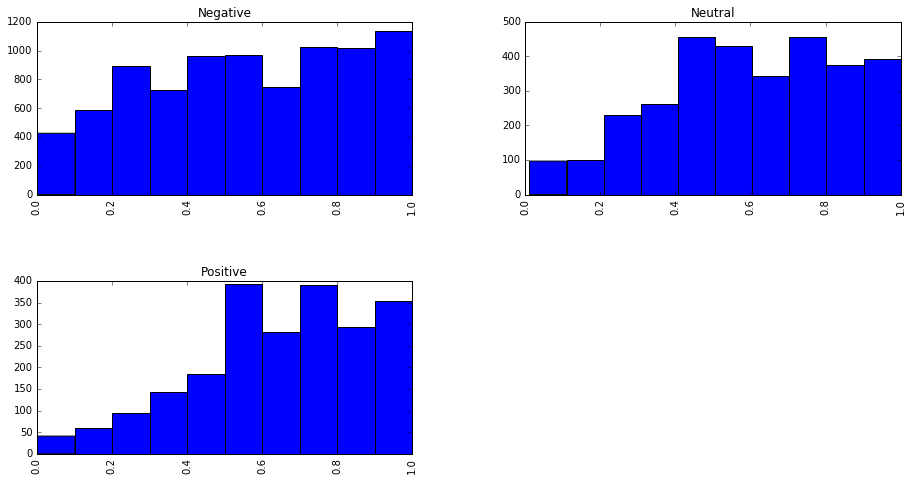

In [499]:
# Create histograms of the NaiveBayesAnalyzer's p(pos) by Kaggle-assigned sentiment.
# Note that p(pos) + p(neg) = 1, so we don't need to plot them both.

K_neg = df[df['K_sentiment']=="Negative"]
K_pos = df[df['K_sentiment']=="Positive"]
K_neu = df[df['K_sentiment']=="Neutral"]

#plt.figure(figsize=(15,10))
#plt.scatter( K_neg.b_subjectivity_num, K_neg.b_polarity_num, s=K_neg.retweet_count/5, c='r', edgecolor='r', label='K=Neg')
#plt.scatter( K_pos.b_subjectivity_num, K_pos.b_polarity_num, s=K_pos.retweet_count/5, c='g', edgecolor='g', label='K=Pos')
#plt.scatter( K_neu.b_subjectivity_num, K_neu.b_polarity_num, s=K_neu.retweet_count/5, c='b', edgecolor='b', label='K=Neu')
#plt.scatter( K_neg.b_p_pos, K_neg.b_p_neg, s=1, c='r', edgecolor='r', label='K=Neg')
#plt.scatter( K_pos.b_p_pos, K_pos.b_p_neg, s=20, c='g', edgecolor='g', label='K=Pos')
#plt.scatter( K_neu.b_p_pos, K_neu.b_p_neg, s=20, c='b', edgecolor='b', label='K=Neu')
#plt.legend()

df[['nb_p_pos']].hist(by=df['K_sentiment'], figsize=(15,8))


In [500]:
# Is agreement with the Kaggle data better for tweets where the two TextBlob classifiers agree?

agr = get_agreement(df[df['b_sentiment']==df['nb_sentiment']], 'K_sentiment', 'nb_sentiment')
denom = df[df['b_sentiment']==df['nb_sentiment']].shape[0]
print float(agr)*100/denom, "% agreement (", agr, "out of", denom, ")"

confusion_df = get_confusion_matrix(df[df['b_sentiment']==df['nb_sentiment']], 'K_sentiment', 'b_sentiment')
print confusion_df
print 'done'

# Agreement is a bit better, but still poor.

47.9792147806 % agreement ( 2493 out of 5196 )
<type 'numpy.ndarray'>
vals= ['Neutral' 'Positive' 'Negative']
  K_sentiment  Negative  Neutral  Positive
0    Negative      1547      403      1208
1     Neutral       310      216       521
2    Positive       127      134       730
done


In [501]:
# Look at some tweets where Kaggle and default sentiment analyzer disagree.
df_KvsD = df[df['K_sentiment']!=df['b_sentiment']]
#print df_KvsD.shape
#df_KvsD[['ascii', 'K_sentiment', 'b_sentiment']].head(100)

# Look at some tweets where Kaggle and NaiveBayes sentiment analyzer disagree.
df_KvsNB = df[df['K_sentiment']!=df['nb_sentiment']]
#print df_KvsNB.shape
#df_KvsNB[['ascii', 'K_sentiment', 'nb_sentiment']].head(100)

# Look at some tweets where ...
#df[ ((df['K_sentiment']=='Positive') & (df['nb_sentiment']=='Positive')) ][['ascii', 'K_sentiment', 'b_sentiment', 'nb_sentiment']].head(100)
#df[ ((df['b_sentiment']==df['nb_sentiment'])) ][['ascii', 'text', 'K_sentiment', 'b_sentiment', 'nb_sentiment']].head(100)
df[ ((df['K_sentiment']=='Negative') & (df['b_sentiment']!='Negative') & (df['nb_sentiment']!='Negative')) ][['ascii', 'text', 'K_sentiment', 'b_sentiment', 'nb_sentiment']].head(100)


,ascii,text,K_sentiment,b_sentiment,nb_sentiment
6,RT warriorwoman91 I liked her and was happy when I heard she was going to be the moderator. Not anymore. GOPDebate megynkelly,RT @warriorwoman91: I liked her and was happy when I heard she was going to be the moderator. Not anymore. #GOPDebate @megynkelly https://…,Negative,Positive,Positive
12,Me reading my familys comments about how great the GOPDebate was,Me reading my family's comments about how great the #GOPDebate was http://t.co/gIaGjPygXZ,Negative,Positive,Positive
16,RT CarolCNN DonaldTrump under fire for comments about women PeterBeinart SL_Schaeffer IWF MyRkiger weigh in on GOPdebate,RT @CarolCNN: #DonaldTrump under fire for comments about women @PeterBeinart @SL_Schaeffer @IWF @@MyRkiger weigh in on #GOPdebate http://t.…,Negative,Neutral,Positive
19,"RT PamelaGeller Huckabee Paying for transgender surgery for soldiers, sailors and airmen does not make our country safer Ha GOPDebate","RT @PamelaGeller: Huckabee: Paying for transgender surgery for soldiers, sailors and airmen does not make our country safer #Ha #GOPDebate",Negative,Neutral,Positive
24,RT MrPooni Fox News trying to convince us young Black Americans are more worried about ISIS than police terrorism GOPDebate,RT @MrPooni: Fox News trying to convince us young Black Americans are more worried about ISIS than police terrorism #GOPDebate http://t.co/…,Negative,Positive,Positive
29,RT HillaryClinton Watch the GOPdebate? Bet you feel like donating to a Democrat right about now.,RT @HillaryClinton: Watch the #GOPdebate? Bet you feel like donating to a Democrat right about now. http://t.co/pGlQCqQgOP http://t.co/QP1e…,Negative,Positive,Positive
35,"RT AmyMek The Torched has been passed - .CandyCrowley is no longer the most Famous Political Assassin! Congratulations megynkelly, U Wi","RT @AmyMek: The Torched has been passed -&gt;.@CandyCrowley is no longer the most Famous Political Assassin! Congratulations @megynkelly, U Wi…",Negative,Positive,Positive
38,"RT ali After the Fox News GOPDebate, we primary voters are none the wiser on the policy plans these folks are putting forth. Journalism","RT @ali: After the Fox News #GOPDebate, we primary voters are none the wiser on the policy plans these folks are putting forth. Journalism …",Negative,Positive,Positive
40,RT mgell Trump is a cross between the shrug emoji and President Business from the Lego movie. GOPDebate,RT @mgell: Trump is a cross between the shrug emoji and President Business from the Lego movie. #GOPDebate,Negative,Neutral,Positive
41,"RT JamelleMyBelle Meanwhile, in the White House... GOPDebate","RT @JamelleMyBelle: Meanwhile, in the White House... #GOPDebate http://t.co/nouUUt5hKq",Negative,Neutral,Neutral


In [ ]:
### DO NOT USE BELOW THIS POINT ###

In [81]:
print df['text'].ix[1]
t = df['text'].ix[1]
print type(t)
bt = TextBlob(t)
print type(bt)
bt.sentiment


RT ScottWalker: Didnt catch the full GOPdebate last night. Here are some of Scotts best lines in 90 seconds. Walker16 http://t.co/ZSfF
<type 'str'>
<class 'textblob.blob.TextBlob'>


Sentiment(polarity=0.45, subjectivity=0.3055555555555556)

In [77]:
testimonial = TextBlob("Textblob is terrible.")
testimonial.sentiment

Sentiment(polarity=-1.0, subjectivity=1.0)

In [54]:
testimonial = TextBlob("RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http:/t.co/ZSfF")
#print testimonial
testimonial.sentiment

Sentiment(polarity=0.45, subjectivity=0.3055555555555556)